In [35]:
!pip install tensorflow-gpu==2.0.0-alpha0 
!pip install  tfp-nightly

# 1.3 High-dimensional Data

## PixelCNN

In [0]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from utils import *
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

In [0]:
np.random.seed(0)
tf.random.set_seed(0)
NUM_EPOCHS = 50
BATCH_SIZE = 128

In [0]:
with open('./mnist-hw1.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [0]:
# Prepare for the train/val data set.
train_raw = data['train'].astype(np.float32)
test = data['test'].astype(np.float32)

train = train_raw[:int(len(train_raw)*0.8)].astype(np.float32)
val = train_raw[int(len(train_raw)*0.8):].astype(np.float32)

train_dset = tf.data.Dataset.from_tensor_slices(train).\
                                repeat(1).batch(BATCH_SIZE)
val_dset = tf.data.Dataset.from_tensor_slices(val).\
                                    batch(BATCH_SIZE)
test_dset = tf.data.Dataset.from_tensor_slices(test).\
                                    batch(BATCH_SIZE)

In [0]:
pixel_cnn = PixelCNN(128, 3*4)

In [0]:
# Create metrics
loss_metric = tf.keras.metrics.Mean(name='train_loss')
val_loss_metric = tf.keras.metrics.Mean(name='val_loss')
optimizer = tf.keras.optimizers.Adam(0.0001)
#train_loss_history = []
#val_loss_history = []

# Define train/val steps
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        x = tf.cast(x, tf.float32)
        prob = pixel_cnn(x)
        log_loss = nll(prob, tf.reshape(x, [tf.shape(x)[0], 28*28*3]))
    var = pixel_cnn.trainable_variables
    gradients = tape.gradient(log_loss, var)
    optimizer.apply_gradients(zip(gradients, var))
    # Update the metrics
    loss_metric.update_state(log_loss)
 

@tf.function
def val_step(x):
    x = tf.cast(x, tf.float32)
    prob = pixel_cnn(x)
    log_loss = nll(prob, tf.reshape(x, [tf.shape(x)[0], 28*28*3]))
    val_loss_metric.update_state(log_loss)

In [46]:
for epoch in range(NUM_EPOCHS):
    # Reset the metrics
    loss_metric.reset_states()
    train_dset = train_dset.shuffle(buffer_size=10000)
    for train_data in train_dset:
        train_step(train_data)
        
    # Repeat the same process for val set
    val_loss_metric.reset_states()
    for val_data in val_dset:
        val_step(val_data)
    # Get the metric results
    mean_loss = loss_metric.result().numpy()
    mean_val_loss = val_loss_metric.result().numpy()
    mean_loss = np.log2(np.exp(mean_loss)) 
    mean_val_loss = np.log2(np.exp(mean_val_loss))
    train_loss_history.append(mean_loss)
    val_loss_history.append(mean_val_loss)

    print('Epoch: ', epoch)
    print('  train loss:     {:.3f}'.format(mean_loss))
    print('  val loss: {:.3f}'.format(mean_val_loss))

Epoch:  0
  train loss:     0.152
  val loss: 0.152
Epoch:  1
  train loss:     0.151
  val loss: 0.152


KeyboardInterrupt: ignored

In [0]:
make_dir('./test')
pixel_cnn.save_weights('./test/test_weight', save_format='tf')

In [0]:
p.load_weights('./test/test_weight')

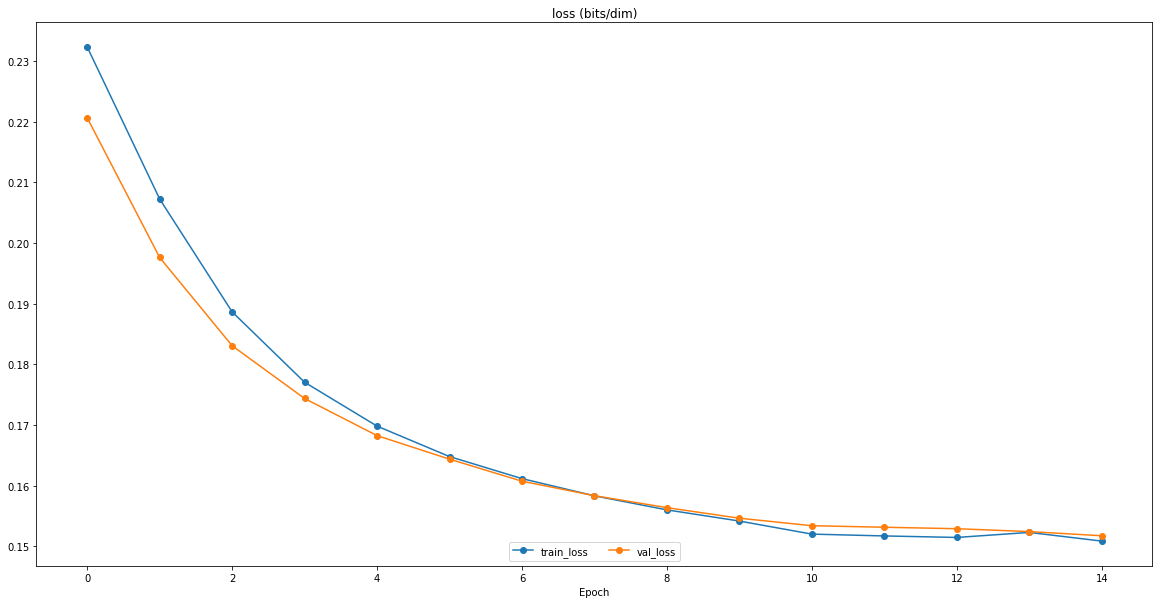

In [49]:
plot_training_history('loss (bits/dim)','Epoch', val_loss_history, [train_loss_history], 
                     train_marker='-o', val_marker='-o')
plt.gcf().set_size_inches(20, 10)
plt.show()